In [2]:
import pandas as pd
import numpy as np
import os, io
import subprocess
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from platform import python_version
from astropy.visualization import ZScaleInterval
import astropy.units as u
import sys

sys.path.append("/home/bethany/ciao-4.12/")
sys.path.append("/home/bethany/ciao-4.12/bin")

In [3]:
print(python_version())

3.7.5


In [52]:
def bash_command(cmd, print_output=True):
    # For ubuntu terminal but may work on Mac (let me know if it doesnt!)
    # Issue command to terminal after loading a bashrc or bashprofile
    print(f"Running Command: {cmd}")
    output = subprocess.check_output(["/bin/bash", "-i", "-c", cmd])
    if print_output:
        return output


def format_obs_id_output(output):
    # The shell output is in bytes, convert to string
    string = output.decode("utf-8")
    # Split string into rows
    block = string.split("\n")[4:]
    # Take out the octothorpe so it isnt counted as na extra column
    block[
        0
    ] = "obsid  sepn   inst grat   time    obsdate      piname                                               target"
    # Convert output to pandas dataframe
    df = pd.read_csv(io.StringIO("\n".join(block)), delim_whitespace=True)

    return df


def locate(ra, dec, radius=1):
    # radius is set to the default of 1 arcmin
    # sepn is also in arcmin
    return bash_command(
        "ciao_init; find_chandra_obsid %s %s radius=%s" % (ra, dec, radius)
    )


def download(obsid):
    # If more than one id is passed from pandas dataframe
    if type(obsid) == pd.core.series.Series:
        # Get string of comma separated values without brackets
        obsid = str(list(obsid))[1:-1].replace(" ", "")
    # Download
    out = bash_command("ciao_init; download_chandra_obsid %s" % obsid)
    return out.decode("utf-8").split("\n")


def reprocess(obsid, outdir):
    # Create new folder with data_reduced files
    out = bash_command("ciao_init; chandra_repro %s outdir=%s" % (obsid, outdir))
    return out


def cleanup(obsid):
    # Remove non-reduced folder
    out = bash_command("rm -r %s" % obsid)
    return out


def move(obsid, folder_name):
    # Check if Target Name Folder Exists
    if os.path.isdir("%s_repro" % obsid) == False:
        # If Not, Create It
        bash_command("mkdir %s" % folder_name)
    # Move obsid to target folder name
    out = bash_command("mv %s_repro %s" % (obsid, folder_name))
    return out


def estimate_nh(ra, dec):
    # From log: Using map h1_nh_HI4PI.fits'

    # Previous 'nh' versions used different maps to derive NH values.
    # They are the (a) HI map by Kalberla et al. 2005, Astronomy & Astrophysics, 440, 775, known as the Leiden/Argentine/Bonn (LAB) survey and
    # (b) the HI map by Dickey & Lockman (DL), 1990, Ann. Rev. Ast. Astr. 28, 215. They are still released with the software for back compatibility;
    # however, the HI4PI map outperforms the LAB and DL maps

    output = bash_command("heainit; nh equinox=2000 ra=%s dec=%s" % (ra, dec))
    log = output.decode("utf-8").split("\n")

    # Get table and convert to pandas
    begin = 12
    far_end = 30
    return_found = 2
    for i in range(begin - 1, far_end):
        if log[i].find("nH") == return_found:
            end = i
            break
    nh_table = log[begin - 1 : end - 1]

    nh_df = pd.read_csv(io.StringIO("\n".join(nh_table)), delim_whitespace=True)

    # Take the nH value that was closest to source
    min_dist = np.min(nh_df["Dist"])  # in degrees
    nh = nh_df["nH"][nh_df["Dist"] == min_dist]
    print(f"Arcmin from source:{min_dist * 60}")

    # absmodel = xsphabs.abs1
    # need to convert to these units which is 10^22 cm^-2
    # https://cxc.cfa.harvard.edu/sherpa/ahelp/xsphabs.html
    nh_xsphabs = nh / 1e22

    return str(np.array(nh_xsphabs))[1:-1]


def get_coords(obsid, ra, dec):
    fname = "%s_repro/*_repro_evt2.fits" % (obsid)
    command = f"ciao_init; dmcoords {fname} ra='{ra}' dec='{dec}'"
    out = bash_command(command)
    print(command)
    print(out)

    return out


def source_flux(obsid, ra, dec):
    fname = "%s_repro/*_repro_evt2.fits" % (obsid)
    # Note: need to fix leading 0 issue - i forgot what this issue was lol
    # outname = '%s_flux/' % obsid
    outname = "flux_test"
    # out = bash_command('ciao_init; srcflux infile=%s pos=%s %s outroot=%s' % (fname,ra,dec,outname))
    out = bash_command(
        f"ciao_init; srcflux infile={fname} pos='{ra} {dec}' outroot={outname} clobber=yes absparam='abs1.nH={estimate_nh(ra,dec)}' psfmethod=arfcorr conf=0.997 bands='0.3:7:2.3'"
    )
    return out

In [5]:
# A18 SOURCE
c = SkyCoord("01h00m59.7024s" "-72d37m13.728s", unit=(u.hourangle, u.deg))
ra = str(c.ra.deg)
dec = str(c.dec.deg)

In [20]:
# Find OBSIDS
out = locate(ra, dec, 0)
df = format_obs_id_output(out)
df

Running Command: ciao_init; find_chandra_obsid 15.248759999999997 -72.62047999999999 radius=0


,obsid,sepn,inst,grat,time,obsdate,piname,target
0,3525,37.9,ACIS-S,NONE,7.6,2003-02-01,Calibration,"E0102-72[S5,-120,-17.29,0,0]"


In [22]:
# Download Multiple or Single OBSIDS
download(df["obsid"])

['CIAO configuration is complete... ',
 'CIAO 4.12 Monday, November 25, 2019',
 '  bindir      : /home/bethany/ciao-4.12/bin',
 '  CALDB       : 4.9.1',
 'Downloading files for ObsId 3525, total size is 45 Mb.',
 '',
 '  Type     Format      Size  0........H.........1  Download Time Average Rate',
 '  ---------------------------------------------------------------------------',
 '  vv       pdf        18 Mb  ####################            2 s  7735.1 kb/s',
 '  evt1     fits       17 Mb  ####################            2 s  10529.3 kb/s',
 '  evt2     fits        3 Mb  ####################            1 s  2559.4 kb/s',
 '  asol     fits        2 Mb  ####################            1 s  1882.9 kb/s',
 '  bias     fits      495 Kb  ####################          < 1 s  503.5 kb/s',
 '  bias     fits      447 Kb  ####################          < 1 s  463.5 kb/s',
 '  bias     fits      440 Kb  ####################          < 1 s  444.8 kb/s',
 '  bias     fits      438 Kb  ################

In [ ]:
# Reprocess OBSIDS

for obsid in df["obsid"]:
    if os.path.isdir("%s_repro" % obsid):
        
        print(f"OBSID {obsid} Has Already Been Reprocessed")
    
    else:
        # Reduce
        r = reprocess("%s" % obsid, "%s_repro" % obsid)
        print(r)

    # If Reprocess was successful
    if os.path.isdir("%s_repro" % obsid):
        # Delete Un Processed Data
        c = cleanup(obsid)
    print(c)

In [24]:
# Retrieve flux from obsid (not gauranteed that target is in footprint yet)

obsids = df["obsid"]
source_flux(obsids[0], ra, dec)

Running Command: heainit; nh equinox=2000 ra=15.248759999999997 dec=-72.62047999999999
Arcmin from source:1.776
Running Command: ciao_init; srcflux infile=3525_repro/*_repro_evt2.fits pos='15.248759999999997 -72.62047999999999' outroot=flux_test clobber=yes absparam='abs1.nH=0.644' psfmethod=arfcorr conf=0.997 bands='0.3:7:2.3'


b'CIAO configuration is complete... \nCIAO 4.12 Monday, November 25, 2019\n  bindir      : /home/bethany/ciao-4.12/bin\n  CALDB       : 4.9.1\nsrcflux\n          infile = 3525_repro/*_repro_evt2.fits\n             pos = 15.248759999999997 -72.62047999999999\n         outroot = flux_test\n           bands = 0.3:7:2.3\n          srcreg = \n          bkgreg = \n         bkgresp = yes\n       psfmethod = arfcorr\n         psffile = \n            conf = 0.997\n         binsize = 1\n         rmffile = \n         arffile = \n           model = xspowerlaw.pow1\n       paramvals = pow1.PhoIndex=2.0\n        absmodel = xsphabs.abs1\n       absparams = abs1.nH=0.644\n           abund = angr\n         fovfile = \n        asolfile = \n         mskfile = \n        bpixfile = \n         dtffile = \n         ecffile = CALDB\n        parallel = yes\n           nproc = INDEF\n          tmpdir = /tmp\n         clobber = yes\n         verbose = 1\n            mode = ql\n\nProcessing OBI 000\nExtracting co

In [23]:
obsids

0    3525
Name: obsid, dtype: int64

In [10]:
im = fits.open("142_repro/hrcf00142_repro_evt2.fits")

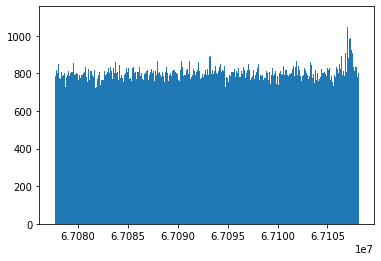

In [11]:
# Considering removing not good time intervals?
# https://sarahspolaor.faculty.wvu.edu/files/d/c5375159-33b3-401a-9664-d21ce3302d9a/project_2.pdf

data = im[1].data

time = data["time"]

plt.hist(time, bins=1000)
;

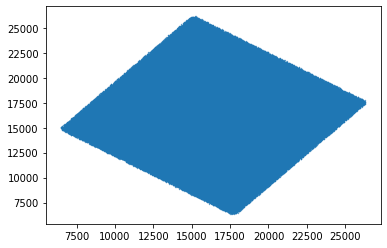

In [29]:
plt.scatter(data["x"], data["y"], s=0.1)

In [36]:
hist, x_edges, y_edges = np.histogram2d(data["x"], data["y"], bins=400)

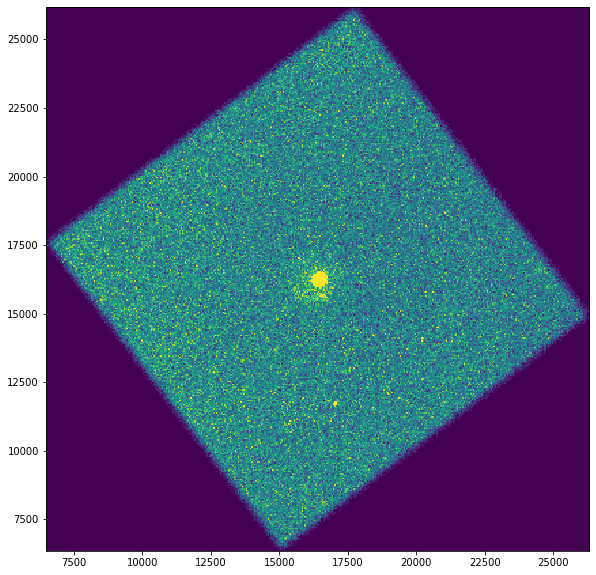

In [41]:
fig = plt.figure(figsize=(10, 10))

interval = ZScaleInterval()
vmin, vmax = interval.get_limits(hist)

plt.imshow(
    hist.T,
    extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]],
    vmin=vmin,
    vmax=vmax,
)

In [15]:
out_coord = get_coords(obsids[1], ra, dec)
out_coord.decode("utf-8").split("\n")

Running Command: ciao_init; dmcoords 11821_repro/*_repro_evt2.fits ra='15.248759999999997' dec='-72.62047999999999'
ciao_init; dmcoords 11821_repro/*_repro_evt2.fits ra='15.248759999999997' dec='-72.62047999999999'
b'CIAO configuration is complete... \nCIAO 4.12 Monday, November 25, 2019\n  bindir      : /home/bethany/ciao-4.12/bin\n  CALDB       : 4.9.1\ndmcoords>: \n'


In [16]:
out_coord.decode("utf-8").split("\n")

['CIAO configuration is complete... ',
 'CIAO 4.12 Monday, November 25, 2019',
 '  bindir      : /home/bethany/ciao-4.12/bin',
 '  CALDB       : 4.9.1',
 'dmcoords>: ',
 '']

In [ ]:
    # The shell output is in bytes, convert to string
    string = output.decode("utf-8")
    # Split string into rows
    block = string.split("\n")[4:]
    # Take out the octothorpe so it isnt counted as na extra column
    block[
        0
    ] = "obsid  sepn   inst grat   time    obsdate      piname                                               target"
    # Convert output to pandas dataframe
    df = pd.read_csv(io.StringIO("\n".join(block)), delim_whitespace=True)

In [47]:
# Chandra Catalog
chandra_cat = pd.read_csv("Chandra_Targets_From_Blue_Select.csv")
chandra_cat

,name,obsid,ra,dec,uvw2_mag,uvm2_mag,uvw1_mag,Umag,Bmag,Vmag,...,uvw1_resid_frac,uvw2_key,uvw2_pix_x,uvw2_pix_y,uvm2_key,uvm2_pix_x,uvm2_pix_y,uvw1_key,uvw1_pix_x,uvw1_pix_y
0,lmc-obs45446-206,45446,86.866710,-69.10210,16.498672,16.613071,16.892548,18.074,19.205,19.461,...,0.102710,2293.0,815.911241,842.028830,2253.0,813.502842,831.329486,2254.0,813.384513,831.905966
1,lmc-obs45461-2273,45461,77.205735,-69.09160,15.964259,16.078821,16.361624,17.214,18.135,18.318,...,0.332938,18787.0,555.746008,639.196503,18712.0,547.948961,625.881969,18742.0,548.507030,624.866812
2,lmc-obs45509-850,45509,86.736660,-70.09345,14.807670,14.951463,15.216103,16.285,17.476,17.687,...,0.106362,9408.0,296.719900,25.716744,9365.0,289.648764,17.322804,9368.0,289.301969,16.792962
3,lmc-obs45516-4349,45516,82.004805,-69.99687,16.271029,16.345757,16.515699,17.680,18.646,18.668,...,0.191100,33181.0,505.158663,159.384071,33199.0,497.720746,151.624527,33230.0,497.994150,151.135152
4,lmc-obs45536-335,45536,83.116425,-70.30682,16.651384,16.562889,17.109678,17.935,19.229,19.244,...,0.170394,16254.0,995.062023,685.350362,16284.0,985.797064,680.172907,16312.0,985.852052,680.809192
5,lmc-obs45578-835,45578,76.194645,-69.04014,15.748439,15.951021,16.239399,17.256,18.410,18.553,...,0.092557,12256.0,912.357800,773.901644,12219.0,905.309862,764.679124,12187.0,906.878255,764.593221
6,smc-obs40416-6198,40416,14.256510,-72.60092,16.152695,16.322170,16.784935,17.525,18.741,18.919,...,0.156510,42178.0,114.605529,764.044874,41772.0,119.635782,761.091749,41795.0,119.908869,762.061480
7,smc-obs40427-981,40427,15.248760,-72.62048,14.451388,14.592916,14.894846,15.957,17.252,17.430,...,0.074500,8822.0,713.453696,417.532786,8788.0,708.597183,423.073685,8821.0,707.944568,422.638175
8,smc-obs40434-2857,40434,14.417040,-71.98791,16.121223,16.266857,16.774771,17.676,18.970,19.204,...,0.133052,14286.0,248.989204,576.233005,14048.0,246.984761,562.645875,14059.0,247.075735,561.989522
9,smc-obs40454-4332,40454,16.001985,-72.27852,16.122719,16.169580,16.420031,17.701,18.966,19.204,...,0.231487,15456.0,751.960354,216.781063,15267.0,748.886096,203.938831,15247.0,749.640868,203.599793


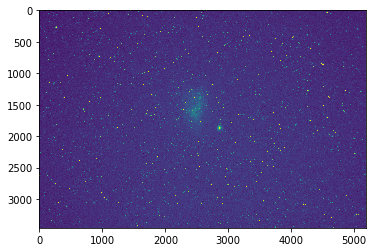

In [88]:
path = 'anna_smc.fits'
data = fits.open(path)[0].data
header = fits.open(path)[0].header


plt.imshow(data[1,:,:])

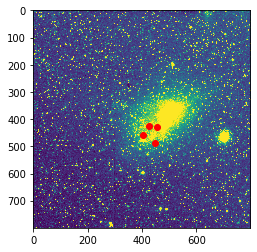

In [98]:
path = '/home/bethany/Desktop/StrippedBinaries/Photometry/Galaxy_Maps/smcrwcs.fits'

data = fits.open(path)[0].data
header = fits.open(path)[0].header


z = ZScaleInterval()
zmin,zmax = z.get_limits(data)


x,y = WCS(header).all_world2pix(chandra_cat.ra.iloc[6:10],chandra_cat.dec.iloc[6:10],0)

plt.imshow(data,vmin=zmin,vmax=zmax)
plt.scatter(x,y,c='r')

In [93]:
WCS(header,naxis=3).all_world2pix(14.256510,-72.60092,0)

KeyError: "Keyword 'CTYPE3' not found."

In [69]:
# How Close Is The LMC Source To LMC-X1 ? 
co = SkyCoord(chandra_cat.ra.iloc[2],chandra_cat.dec.iloc[2],unit=u.deg)
co2 = SkyCoord("05h39m38.8s","-69d44m35.5s",frame="icrs")
co2.separation(co).arcminute

43.06998587325887

In [55]:
chandra_cat['name'].iloc[n:]

3     lmc-obs45516-4349
4      lmc-obs45536-335
5      lmc-obs45578-835
6     smc-obs40416-6198
7      smc-obs40427-981
8     smc-obs40434-2857
9     smc-obs40454-4332
10    smc-obs40454-6519
Name: name, dtype: object

In [58]:
n = 3
for name, ra, dec in zip(chandra_cat["name"].iloc[n:], chandra_cat["ra"].iloc[n:], chandra_cat["dec"].iloc[n:]):

    print(f"Searching for : {name}")

    # Find OBSIDS
    out = locate(ra, dec, 0)
    df = format_obs_id_output(out)
    print(df)

    # Download Multiple or Single OBSIDS
    download(df["obsid"])

    # Reprocess OBSIDS

    for obsid in df["obsid"]:
        if os.path.isdir("%s_repro" % obsid):

            print(f"OBSID {obsid} Has Already Been Reprocessed")

        else:
            # Reduce
            r = reprocess("%s" % obsid, "%s_repro" % obsid)
            print(r)

        # If Reprocess was successful
        if os.path.isdir("%s_repro" % obsid):
            # Delete Un Processed Data
            c = cleanup(obsid)
        print(c)

        move(obsid, name)

Searching for : lmc-obs45516-4349
Running Command: ciao_init; find_chandra_obsid 82.004805 -69.99687 radius=0
Empty DataFrame
Columns: [obsid, sepn, inst, grat, time, obsdate, piname, target]
Index: []
Running Command: ciao_init; download_chandra_obsid 
Searching for : lmc-obs45536-335
Running Command: ciao_init; find_chandra_obsid 83.11642499999998 -70.30682 radius=0
Empty DataFrame
Columns: [obsid, sepn, inst, grat, time, obsdate, piname, target]
Index: []
Running Command: ciao_init; download_chandra_obsid 
Searching for : lmc-obs45578-835
Running Command: ciao_init; find_chandra_obsid 76.194645 -69.04014000000001 radius=0
Empty DataFrame
Columns: [obsid, sepn, inst, grat, time, obsdate, piname, target]
Index: []
Running Command: ciao_init; download_chandra_obsid 
Searching for : smc-obs40416-6198
Running Command: ciao_init; find_chandra_obsid 14.25651 -72.60092 radius=0
   obsid  sepn    inst  grat  time     obsdate piname         target
0  14668   4.1  ACIS-I  NONE  49.4  2013-01-0